<a href="https://colab.research.google.com/github/lilyariver-design/Zarplata/blob/main/new_Nechepurenko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import statsmodels.api as sm

In [11]:
item = 'gss_wages' # Выбрать из поля Item для вашего датасета
package = 'stevedata' # Выбрать из поля Package для вашего датасета

df = sm.datasets.get_rdataset(item, package , cache=True).data
df.head()

year  realrinc   age   occ10                          occrecode  prestg10  \
0  1974    4935.0  21.0  5620.0  Office and Administrative Support      25.0   
1  1974   43178.0  41.0  2040.0                       Professional      66.0   
2  1974       NaN  83.0     NaN                                NaN       NaN   
3  1974       NaN  69.0     NaN                                NaN       NaN   
4  1974   18505.0  58.0  5820.0  Office and Administrative Support      37.0   

   childs      wrkstat  gender                educcat     maritalcat  
0     0.0       School    Male            High School        Married  
1     3.0    Full-Time    Male               Bachelor        Married  
2     2.0  Housekeeper  Female  Less Than High School        Widowed  
3     2.0  Housekeeper  Female  Less Than High School        Widowed  
4     0.0    Full-Time  Female            High School  Never Married

In [12]:
# установка YData Profiling
!pip install -q ydata-profiling

In [13]:
from ydata_profiling import ProfileReport

# создание отчета
profile = ProfileReport(df, title='Pandas Profiling Report')

In [14]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 11/11 [00:02<00:00,  5.49it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Это нам надо - поэтому сохраним.

In [15]:
profile.to_file("gss_wages_profile.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# инфо о столбцах датасета
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61697 entries, 0 to 61696
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        61697 non-null  int64  
 1   realrinc    37887 non-null  float64
 2   age         61478 non-null  float64
 3   occ10       58136 non-null  float64
 4   occrecode   58136 non-null  object 
 5   prestg10    57511 non-null  float64
 6   childs      61508 non-null  float64
 7   wrkstat     61676 non-null  object 
 8   gender      61697 non-null  object 
 9   educcat     61562 non-null  object 
 10  maritalcat  61670 non-null  object 
dtypes: float64(5), int64(1), object(5)
memory usage: 5.2+ MB


In [17]:
# статистики по столбцам
df.describe()

year       realrinc           age         occ10      prestg10  \
count  61697.000000   37887.000000  61478.000000  58136.000000  57511.000000   
mean    1996.073715   22326.359234     46.176177   4695.774081     43.060701   
std       12.794470   28581.794499     17.561065   2627.724076     12.987526   
min     1974.000000     227.000000     18.000000     10.000000     16.000000   
25%     1985.000000    8156.000000     32.000000   2710.000000     33.000000   
50%     1996.000000   16563.000000     44.000000   4720.000000     42.000000   
75%     2006.000000   27171.000000     59.000000   6230.000000     50.000000   
max     2018.000000  480144.472857     89.000000   9997.000000     80.000000   

             childs  
count  61508.000000  
mean       1.923457  
std        1.763569  
min        0.000000  
25%        0.000000  
50%        2.000000  
75%        3.000000  
max        8.000000

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings
warnings.filterwarnings("ignore")

# === 1. ЗАГРУЗКА ДАННЫХ ===
df = pd.read_csv("gss_wages.csv", header=None)

# Присваиваем колонки
df.columns = [
    "id", "year", "realrinc", "age", "occ10", "occupation", "prestg10",
    "childs", "wrkstat", "gender", "educcat", "maritalcat"
]

# Удаляем строки без дохода
df = df.dropna(subset=["realrinc"]).copy()
print(f"Размер после удаления NaN в realrinc: {df.shape}")

# === 2. ОБРАБОТКА EDUCATION ===
edu_map = {
    "Less Than High School": 10,
    "High School": 12,
    "Junior College": 14,
    "Bachelor": 16,
    "Graduate": 18
}

# Преобразуем educcat → education_num, всё, что не в словаре → NaN
df["education_num"] = df["educcat"].map(edu_map)

# Удаляем строки, где education_num не определён
df = df.dropna(subset=["education_num"]).copy()

# Явно приводим к целому числу
df["education_num"] = df["education_num"].astype(int)

# === 3. ПОЛ ===
df["is_male"] = (df["gender"] == "Male").astype(int)

# === 4. ЗАНЯТОСТЬ ===
employed_statuses = ["Full-Time", "Part-Time", "Temporarily Not Working"]
df["is_employed"] = df["wrkstat"].isin(employed_statuses).astype(int)

# === 5. ПРОИЗВОДНЫЕ ПРИЗНАКИ ===
# Убедимся, что age и education_num — числа
df["age"] = pd.to_numeric(df["age"], errors='coerce')
df["prestg10"] = pd.to_numeric(df["prestg10"], errors='coerce')

# Удаляем строки, где age или prestg10 стали NaN после преобразования
df = df.dropna(subset=["age", "prestg10"]).copy()

# Теперь безопасно вычисляем
df["work_experience"] = df["age"] - df["education_num"] - 6
df["work_experience"] = df["work_experience"].clip(lower=0)
df["age_squared"] = df["age"] ** 2
df["experience_squared"] = df["work_experience"] ** 2

# === 6. ONE-HOT ДЛЯ MARITAL ===
marital_dummies = pd.get_dummies(df["maritalcat"], prefix="marital")
needed_marital = ["marital_Married", "marital_Never Married", "marital_Widowed", "marital_Separated"]
for col in needed_marital:
    if col not in marital_dummies.columns:
        marital_dummies[col] = 0
marital_dummies = marital_dummies[needed_marital]
df = pd.concat([df, marital_dummies], axis=1)

# === 7. ВЫБОР ПРИЗНАКОВ ===
feature_columns = [
    "prestg10", "education_num", "is_male", "childs", "age",
    "experience_squared", "work_experience", "age_squared",
    "marital_Married", "is_employed",
    "marital_Never Married", "marital_Widowed", "marital_Separated"
]

X = df[feature_columns]
y = df["realrinc"]

# Удаляем строки с NaN в признаках
X = X.dropna()
y = y[X.index]  # синхронизируем y

print(f"Финальный размер датасета: {X.shape}")

# === 8. РАЗДЕЛЕНИЕ ===
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# === 9. ОБУЧЕНИЕ ===
print("Обучение модели...")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# === 10. ОЦЕНКА ===
def evaluate(name, X, y):
    pred = rf.predict(X)
    r2 = r2_score(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))
    print(f"{name} → R²: {r2:.4f}, RMSE: {rmse:,.2f}")

evaluate("Train", X_train, y_train)
evaluate("Val", X_val, y_val)
evaluate("Test", X_test, y_test)

# === 11. СОХРАНЕНИЕ ===
joblib.dump(rf, "random_forest_model.pkl")
print("\n✅ Модель сохранена в random_forest_model.pkl")

# === 12. ВАЖНОСТЬ ПРИЗНАКОВ ===
importances = pd.DataFrame({
    "Признак": feature_columns,
    "Важность": rf.feature_importances_
}).sort_values("Важность", ascending=False)
print("\nТОП-5 признаков:")
print(importances.head())
importances.to_csv("feature_importance_generated.csv", index=False)

Размер после удаления NaN в realrinc: (37888, 12)
Финальный размер датасета: (37189, 13)
Обучение модели...
Train → R²: 0.4553, RMSE: 22,354.14
Val → R²: 0.2682, RMSE: 22,289.28
Test → R²: 0.2520, RMSE: 22,331.85

✅ Модель сохранена в random_forest_model.pkl

ТОП-5 признаков:
         Признак  Важность
0       prestg10  0.262060
1  education_num  0.186668
2        is_male  0.100612
4            age  0.099558
7    age_squared  0.097445


In [19]:
# дубликаты
df.duplicated().sum()

np.int64(0)

In [20]:
# кол-во пропусков
df.isna().sum()

id                        0
year                      0
realrinc                  0
age                       0
occ10                     0
occupation                0
prestg10                  0
childs                   77
wrkstat                   0
gender                    0
educcat                   0
maritalcat                4
education_num             0
is_male                   0
is_employed               0
work_experience           0
age_squared               0
experience_squared        0
marital_Married           0
marital_Never Married     0
marital_Widowed           0
marital_Separated         0
dtype: int64

Откуда эти пропуски? ...ррр

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings
warnings.filterwarnings("ignore")

# === 1. ЗАГРУЗКА ДАННЫХ ===
df = pd.read_csv("gss_wages.csv", header=None)

# Присваиваем колонки
df.columns = [
    "id", "year", "realrinc", "age", "occ10", "occupation", "prestg10",
    "childs", "wrkstat", "gender", "educcat", "maritalcat"
]

# 🔑 КРИТИЧЕСКИ ВАЖНО: преобразуем целевую переменную в числовой формат
df["realrinc"] = pd.to_numeric(df["realrinc"], errors='coerce')

# Удаляем строки, где realrinc не удалось преобразовать (остались NaN)
df = df.dropna(subset=["realrinc"]).copy()
print(f"Размер после удаления NaN в realrinc: {df.shape}")

# === 2. ОБРАБОТКА EDUCATION ===
edu_map = {
    "Less Than High School": 10,
    "High School": 12,
    "Junior College": 14,
    "Bachelor": 16,
    "Graduate": 18
}
df["education_num"] = df["educcat"].map(edu_map)

# Удаляем строки, где education не распознано
df = df.dropna(subset=["education_num"]).copy()
df["education_num"] = df["education_num"].astype(int)

# === 3. ПОЛ ===
df["is_male"] = (df["gender"] == "Male").astype(int)

# === 4. ЗАНЯТОСТЬ ===
employed_statuses = ["Full-Time", "Part-Time", "Temporarily Not Working"]
df["is_employed"] = df["wrkstat"].isin(employed_statuses).astype(int)

# === 5. ЗАПОЛНЕНИЕ ПРОПУСКОВ И ПРЕОБРАЗОВАНИЕ ТИПОВ ===
# Преобразуем childs в числовой формат
df["childs"] = pd.to_numeric(df["childs"], errors='coerce')
df["childs"].fillna(df["childs"].median(), inplace=True)

# Обработка maritalcat: замена 'nan' строк и заполнение модой
df["maritalcat"] = df["maritalcat"].astype(str)
valid_marital = df["maritalcat"][df["maritalcat"] != 'nan']
mode_val = valid_marital.mode()[0] if not valid_marital.empty else "Married"
df["maritalcat"].replace('nan', mode_val, inplace=True)
df["maritalcat"].fillna(mode_val, inplace=True)

# === 6. ОБРАБОТКА occ10 (сильный признак профессии) ===
df["occ10"] = pd.to_numeric(df["occ10"], errors='coerce')
df["occ10"].fillna(df["occ10"].median(), inplace=True)

# === 7. ПРОИЗВОДНЫЕ ПРИЗНАКИ ===
df["age"] = pd.to_numeric(df["age"], errors='coerce')
df["prestg10"] = pd.to_numeric(df["prestg10"], errors='coerce')

# Удаляем строки, где age или prestg10 стали NaN
df = df.dropna(subset=["age", "prestg10"]).copy()

df["work_experience"] = df["age"] - df["education_num"] - 6
df["work_experience"] = df["work_experience"].clip(lower=0)
df["age_squared"] = df["age"] ** 2
df["experience_squared"] = df["work_experience"] ** 2

# === 8. ONE-HOT ДЛЯ MARITAL ===
marital_dummies = pd.get_dummies(df["maritalcat"], prefix="marital")
needed_marital = ["marital_Married", "marital_Never Married", "marital_Widowed", "marital_Separated"]
for col in needed_marital:
    if col not in marital_dummies.columns:
        marital_dummies[col] = 0
marital_dummies = marital_dummies[needed_marital]
df = pd.concat([df, marital_dummies], axis=1)

# === 9. ВЫБОР ПРИЗНАКОВ ===
feature_columns = [
    "prestg10", "occ10", "education_num", "is_male", "childs", "age",
    "experience_squared", "work_experience", "age_squared",
    "marital_Married", "is_employed",
    "marital_Never Married", "marital_Widowed", "marital_Separated"
]

X = df[feature_columns].copy()
y = df["realrinc"]

# Убеждаемся, что в X и y нет NaN
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

print(f"Финальный размер датасета: {X.shape}")

# === 10. ЛОГАРИФМИЧЕСКАЯ ТРАНСФОРМАЦИЯ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===
y_log = np.log1p(y)

# === 11. РАЗДЕЛЕНИЕ ДАННЫХ ===
X_train, X_temp, y_train_log, y_temp_log = train_test_split(
    X, y_log, test_size=0.4, random_state=42
)
X_val, X_test, y_val_log, y_test_log = train_test_split(
    X_temp, y_temp_log, test_size=0.5, random_state=42
)

# Сохраняем оригинальные y для оценки в исходных единицах
y_train = y[y_train_log.index]
y_val = y[y_val_log.index]
y_test = y[y_test_log.index]

# === 12. ОБУЧЕНИЕ МОДЕЛИ ===
print("Обучение модели...")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train_log)

# === 13. ОЦЕНКА МОДЕЛИ ===
def evaluate(name, X, y_true, model):
    pred_log = model.predict(X)
    pred = np.expm1(pred_log)  # обратное преобразование
    r2 = r2_score(y_true, pred)
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    print(f"{name} → R²: {r2:.4f}, RMSE: {rmse:,.2f}")

evaluate("Train", X_train, y_train, rf)
evaluate("Val",  X_val,  y_val,  rf)
evaluate("Test", X_test, y_test, rf)

# === 14. СОХРАНЕНИЕ МОДЕЛИ ===
joblib.dump(rf, "random_forest_model.pkl")
print("\n✅ Модель сохранена в random_forest_model.pkl")

# === 15. ВАЖНОСТЬ ПРИЗНАКОВ ===
importances = pd.DataFrame({
    "Признак": feature_columns,
    "Важность": rf.feature_importances_
}).sort_values("Важность", ascending=False)

print("\nТОП-5 признаков:")
print(importances.head())
importances.to_csv("feature_importance_generated.csv", index=False)

Размер после удаления NaN в realrinc: (37887, 12)
Финальный размер датасета: (37266, 14)
Обучение модели...
Train → R²: 0.3946, RMSE: 22,286.87
Val → R²: 0.2444, RMSE: 25,040.55
Test → R²: 0.2577, RMSE: 24,419.66

✅ Модель сохранена в random_forest_model.pkl

ТОП-5 признаков:
       Признак  Важность
0     prestg10  0.233888
1        occ10  0.159599
3      is_male  0.106399
8  age_squared  0.092859
5          age  0.092339


In [22]:
# кол-во пропусков
df.isna().sum()

id                       0
year                     0
realrinc                 0
age                      0
occ10                    0
occupation               0
prestg10                 0
childs                   0
wrkstat                  0
gender                   0
educcat                  0
maritalcat               0
education_num            0
is_male                  0
is_employed              0
work_experience          0
age_squared              0
experience_squared       0
marital_Married          0
marital_Never Married    0
marital_Widowed          0
marital_Separated        0
dtype: int64

ну вот, совсем другое дело)

Матрицу корреляций сделаю целиком

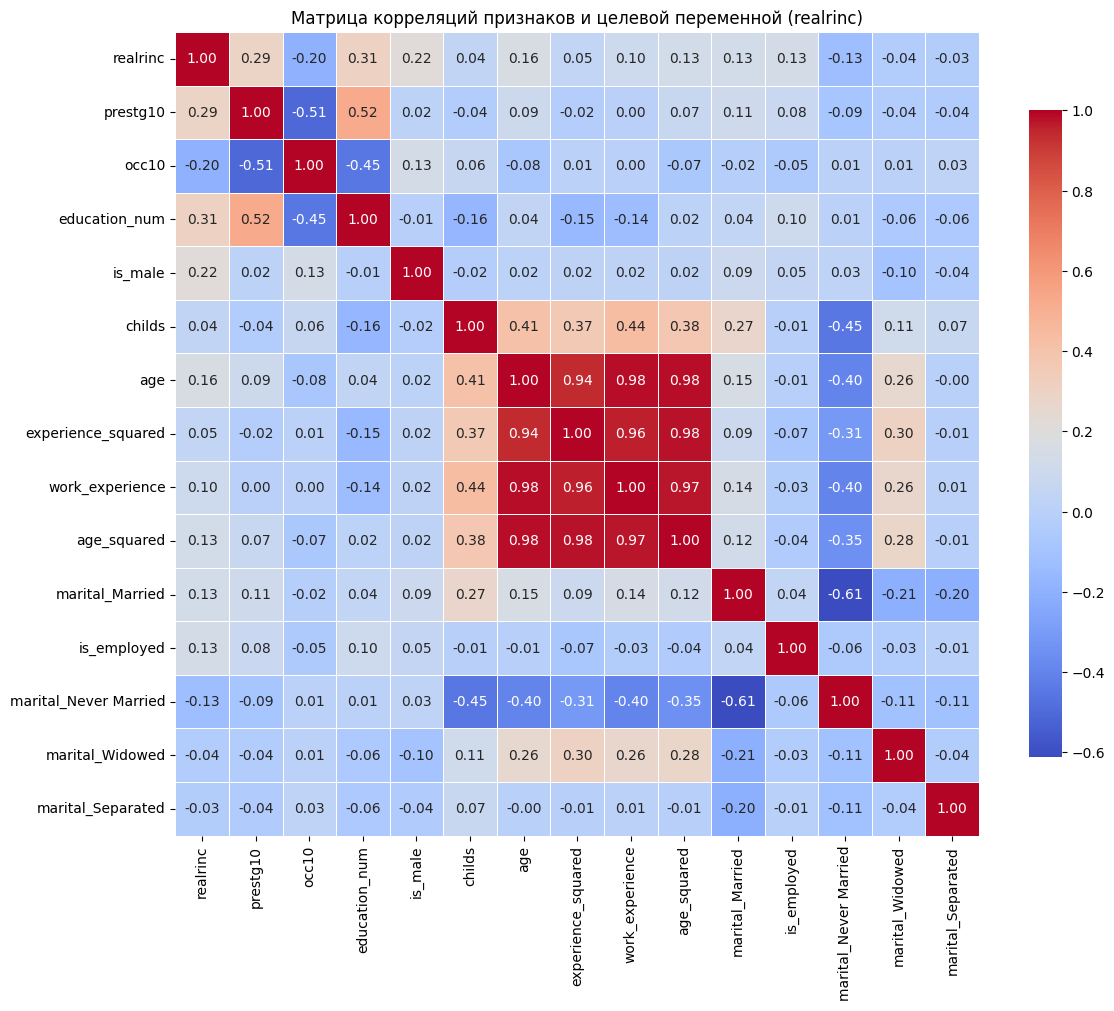

✅ Матрица корреляций сохранена в correlation_matrix.csv


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Загрузка и обработка данных ===
df = pd.read_csv("gss_wages.csv", header=None)
df.columns = [
    "id", "year", "realrinc", "age", "occ10", "occupation", "prestg10",
    "childs", "wrkstat", "gender", "educcat", "maritalcat"
]

# Преобразуем realrinc в числовой
df["realrinc"] = pd.to_numeric(df["realrinc"], errors='coerce')
df = df.dropna(subset=["realrinc"]).copy()

# Обработка образования
edu_map = {
    "Less Than High School": 10,
    "High School": 12,
    "Junior College": 14,
    "Bachelor": 16,
    "Graduate": 18
}
df["education_num"] = df["educcat"].map(edu_map)
df = df.dropna(subset=["education_num"]).copy()
df["education_num"] = df["education_num"].astype(int)

# Пол
df["is_male"] = (df["gender"] == "Male").astype(int)

# Занятость
employed_statuses = ["Full-Time", "Part-Time", "Temporarily Not Working"]
df["is_employed"] = df["wrkstat"].isin(employed_statuses).astype(int)

# Заполнение пропусков
df["childs"] = pd.to_numeric(df["childs"], errors='coerce')
df["childs"].fillna(df["childs"].median(), inplace=True)

df["maritalcat"] = df["maritalcat"].astype(str)
valid_marital = df["maritalcat"][df["maritalcat"] != 'nan']
mode_val = valid_marital.mode()[0] if not valid_marital.empty else "Married"
df["maritalcat"].replace('nan', mode_val, inplace=True)
df["maritalcat"].fillna(mode_val, inplace=True)

# occ10
df["occ10"] = pd.to_numeric(df["occ10"], errors='coerce')
df["occ10"].fillna(df["occ10"].median(), inplace=True)

# Производные признаки
df["age"] = pd.to_numeric(df["age"], errors='coerce')
df["prestg10"] = pd.to_numeric(df["prestg10"], errors='coerce')
df = df.dropna(subset=["age", "prestg10"]).copy()

df["work_experience"] = (df["age"] - df["education_num"] - 6).clip(lower=0)
df["age_squared"] = df["age"] ** 2
df["experience_squared"] = df["work_experience"] ** 2

# One-hot для marital
marital_dummies = pd.get_dummies(df["maritalcat"], prefix="marital")
needed_marital = ["marital_Married", "marital_Never Married", "marital_Widowed", "marital_Separated"]
for col in needed_marital:
    if col not in marital_dummies.columns:
        marital_dummies[col] = 0
marital_dummies = marital_dummies[needed_marital]
df = pd.concat([df, marital_dummies], axis=1)

# Выбор признаков + целевая переменная
feature_columns = [
    "realrinc",  # добавляем целевую переменную для корреляции
    "prestg10", "occ10", "education_num", "is_male", "childs", "age",
    "experience_squared", "work_experience", "age_squared",
    "marital_Married", "is_employed",
    "marital_Never Married", "marital_Widowed", "marital_Separated"
]

X_full = df[feature_columns].copy()
X_full = X_full.dropna()

# === Матрица корреляций ===
corr_matrix = X_full.corr()

# Визуализация
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": .8},
    linewidths=0.5
)
plt.title("Матрица корреляций признаков и целевой переменной (realrinc)")
plt.tight_layout()
plt.show()

# Сохранение в CSV (опционально)
corr_matrix.to_csv("correlation_matrix.csv")
print("✅ Матрица корреляций сохранена в correlation_matrix.csv")

Высокая корреляция между realrinc и prestg10, education_num, occ10 — это ожидаемо.
Мультиколлинеарность между age, age_squared, work_experience — нормально, но стоит учитывать при интерпретации.
Слабая связь у признаков вроде marital_Widowed или childs — согласуется с малой важностью в Random Forest.

In [24]:
print("\nКорреляция признаков с realrinc:")
print(corr_matrix["realrinc"].drop("realrinc").sort_values(ascending=False))


Корреляция признаков с realrinc:
education_num            0.306902
prestg10                 0.293366
is_male                  0.216494
age                      0.157241
is_employed              0.132440
marital_Married          0.129834
age_squared              0.126470
work_experience          0.102421
experience_squared       0.049125
childs                   0.042358
marital_Separated       -0.026926
marital_Widowed         -0.035549
marital_Never Married   -0.128698
occ10                   -0.198798
Name: realrinc, dtype: float64


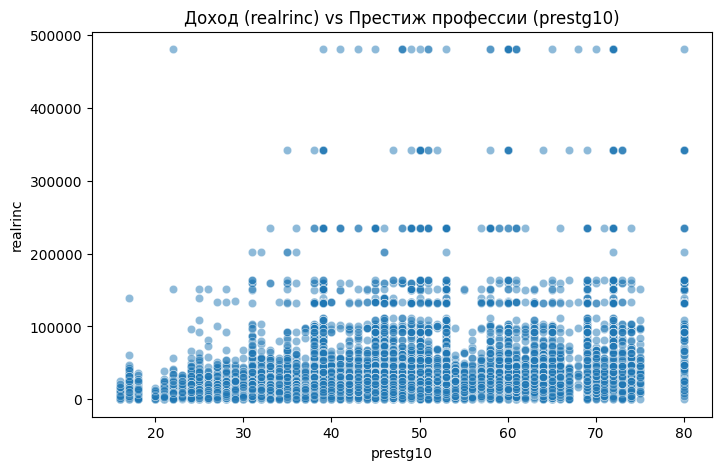

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Пример: realrinc vs prestg10
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="prestg10", y="realrinc", alpha=0.5)
plt.title("Доход (realrinc) vs Престиж профессии (prestg10)")
plt.xlabel("prestg10")
plt.ylabel("realrinc")
plt.show()

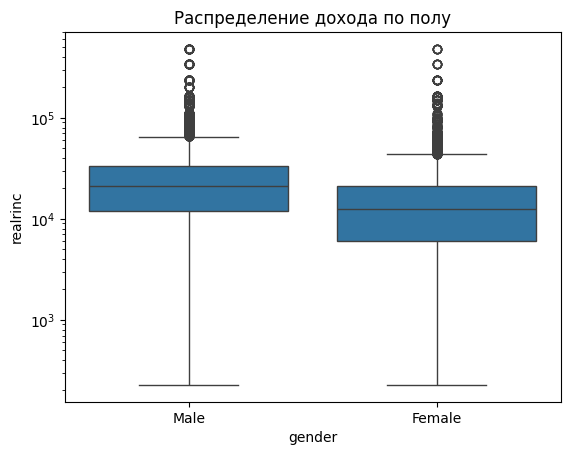

In [26]:
sns.boxplot(data=df, x="gender", y="realrinc")
plt.yscale('log')  # лог-шкала из-за сильного разброса
plt.title("Распределение дохода по полу")
plt.show()

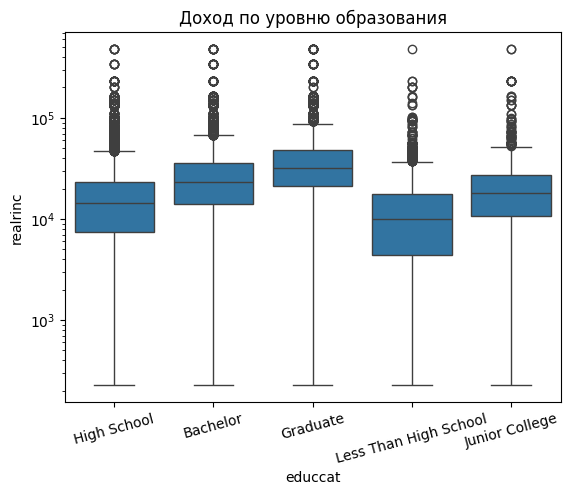

In [27]:
sns.boxplot(data=df, x="educcat", y="realrinc")
plt.yscale('log')
plt.xticks(rotation=15)
plt.title("Доход по уровню образования")
plt.show()

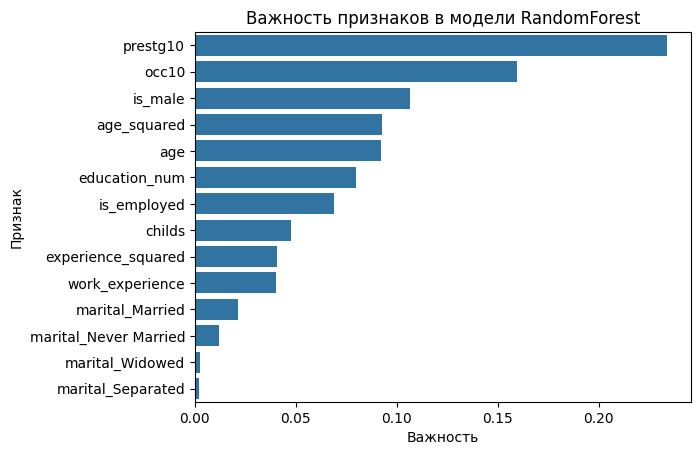

✅ График важности признаков сохранён в feature_importance_plot.png


In [28]:
importances = pd.read_csv("feature_importance_generated.csv")
sns.barplot(data=importances, x="Важность", y="Признак")
plt.title("Важность признаков в модели RandomForest")

plt.savefig("feature_importance_plot.png", dpi=150, bbox_inches='tight')

plt.show()

print("✅ График важности признаков сохранён в feature_importance_plot.png")

Визуализация зависимости дохода (realrinc) от ключевых признаков из вашей модели:

prestg10 (престиж профессии)
education_num (уровень образования в годах)
is_male (пол: 1 = мужчина)
age (возраст)
work_experience (стаж)
marital_Married (женат/замужем)

Очищаем данные аналогично нашей модели (те же шаги).
Удаляем топ-1% самых высоких доходов, чтобы график не искажался выбросами (например, realrinc = 234366).
Используем:
scatterplot для непрерывных признаков (prestg10, age, work_experience)
boxplot для категориальных (education_num, is_male, marital_Married)

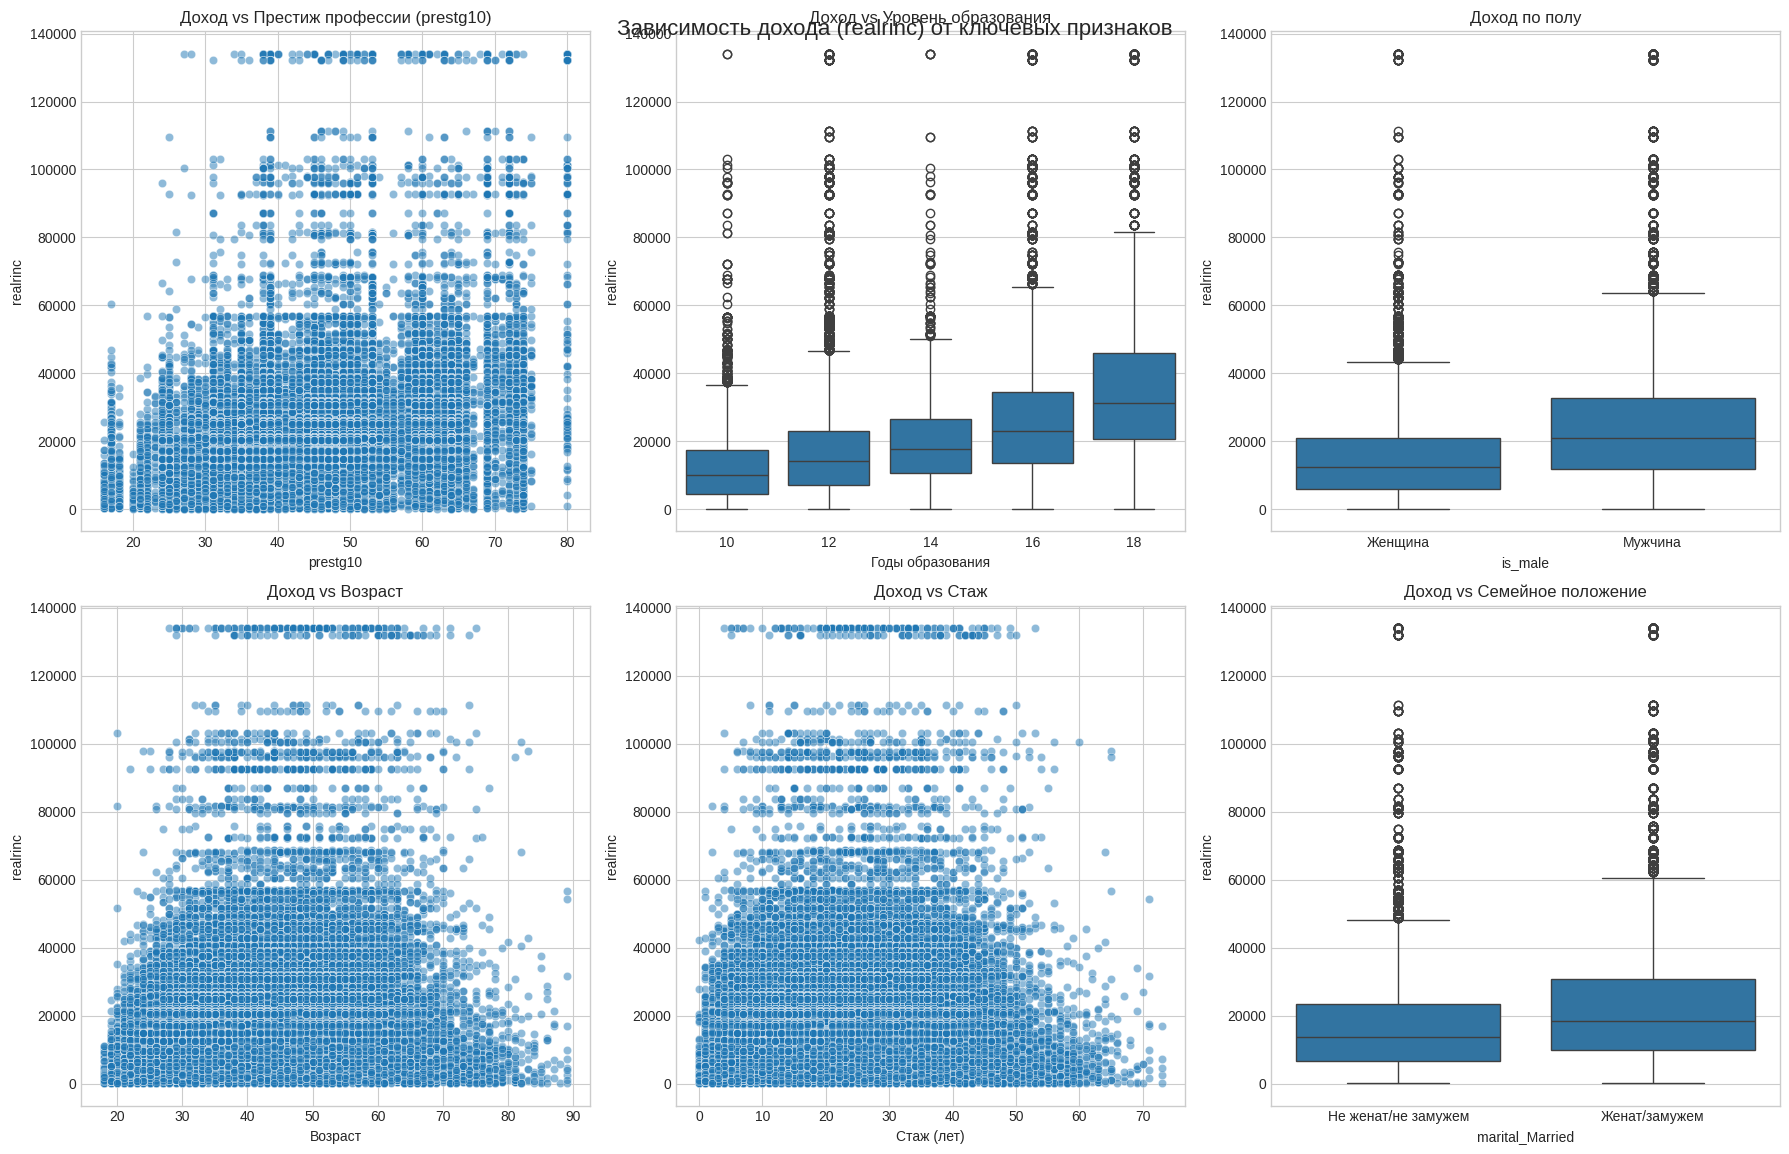

✅ График успешно сохранён в income_vs_features_logscal.png


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ ===
df = pd.read_csv("gss_wages.csv", header=None)
df.columns = [
    "id", "year", "realrinc", "age", "occ10", "occupation", "prestg10",
    "childs", "wrkstat", "gender", "educcat", "maritalcat"
]

# Преобразуем realrinc в числовой
df["realrinc"] = pd.to_numeric(df["realrinc"], errors='coerce')
df = df.dropna(subset=["realrinc"])

# Обработка образования
edu_map = {
    "Less Than High School": 10,
    "High School": 12,
    "Junior College": 14,
    "Bachelor": 16,
    "Graduate": 18
}
df["education_num"] = df["educcat"].map(edu_map)
df = df.dropna(subset=["education_num"])
df["education_num"] = df["education_num"].astype(int)

# Пол
df["is_male"] = (df["gender"] == "Male").astype(int)

# Стаж
df["age"] = pd.to_numeric(df["age"], errors='coerce')
df["prestg10"] = pd.to_numeric(df["prestg10"], errors='coerce')
df = df.dropna(subset=["age", "prestg10"])
df["work_experience"] = (df["age"] - df["education_num"] - 6).clip(lower=0)

# Семейное положение
df["marital_Married"] = (df["maritalcat"] == "Married").astype(int)

# Удаляем экстремальные выбросы (например, 99-й процентиль по доходу)
p99 = df["realrinc"].quantile(0.99)
df = df[df["realrinc"] <= p99]

# === 2. ВИЗУАЛИЗАЦИЯ ===
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Зависимость дохода (realrinc) от ключевых признаков", fontsize=16, y=0.95)

# 1. prestg10
sns.scatterplot(data=df, x="prestg10", y="realrinc", alpha=0.5, ax=axes[0, 0])
axes[0, 0].set_title("Доход vs Престиж профессии (prestg10)")
axes[0, 0].set_xlabel("prestg10")
axes[0, 0].set_ylabel("realrinc")

# 2. education_num
sns.boxplot(data=df, x="education_num", y="realrinc", ax=axes[0, 1])
axes[0, 1].set_title("Доход vs Уровень образования")
axes[0, 1].set_xlabel("Годы образования")
axes[0, 1].set_ylabel("realrinc")

# 3. is_male
sns.boxplot(data=df, x="is_male", y="realrinc", ax=axes[0, 2])
axes[0, 2].set_xticklabels(["Женщина", "Мужчина"])
axes[0, 2].set_title("Доход по полу")
axes[0, 2].set_ylabel("realrinc")

# 4. age
sns.scatterplot(data=df, x="age", y="realrinc", alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title("Доход vs Возраст")
axes[1, 0].set_xlabel("Возраст")
axes[1, 0].set_ylabel("realrinc")

# 5. work_experience
sns.scatterplot(data=df, x="work_experience", y="realrinc", alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title("Доход vs Стаж")
axes[1, 1].set_xlabel("Стаж (лет)")
axes[1, 1].set_ylabel("realrinc")

# 6. marital_Married
sns.boxplot(data=df, x="marital_Married", y="realrinc", ax=axes[1, 2])
axes[1, 2].set_xticklabels(["Не женат/не замужем", "Женат/замужем"])
axes[1, 2].set_title("Доход vs Семейное положение")
axes[1, 2].set_ylabel("realrinc")

plt.tight_layout()

fig.savefig("income_vs_features_logscal.png", dpi=150, bbox_inches='tight')

plt.show()

print("✅ График успешно сохранён в income_vs_features_logscal.png")


ВИДИМ: Чёткую положительную связь между prestg10 и доходом.
Рост дохода с увеличением образования.
Разрыв по полу: мужчины в среднем зарабатывают больше.
Доход растёт с возрастом и стажем, но с насыщением после 50–60 лет.
Женатые — немного выше доход, чем неженатые.

Доход (realrinc) в данных GSS сильно скошен вправо (есть люди с очень высоким доходом).
**Лог-шкала** нормализует визуальное восприятие — теперь  видим не просто "один выброс наверху", а распределение по всему диапазону.

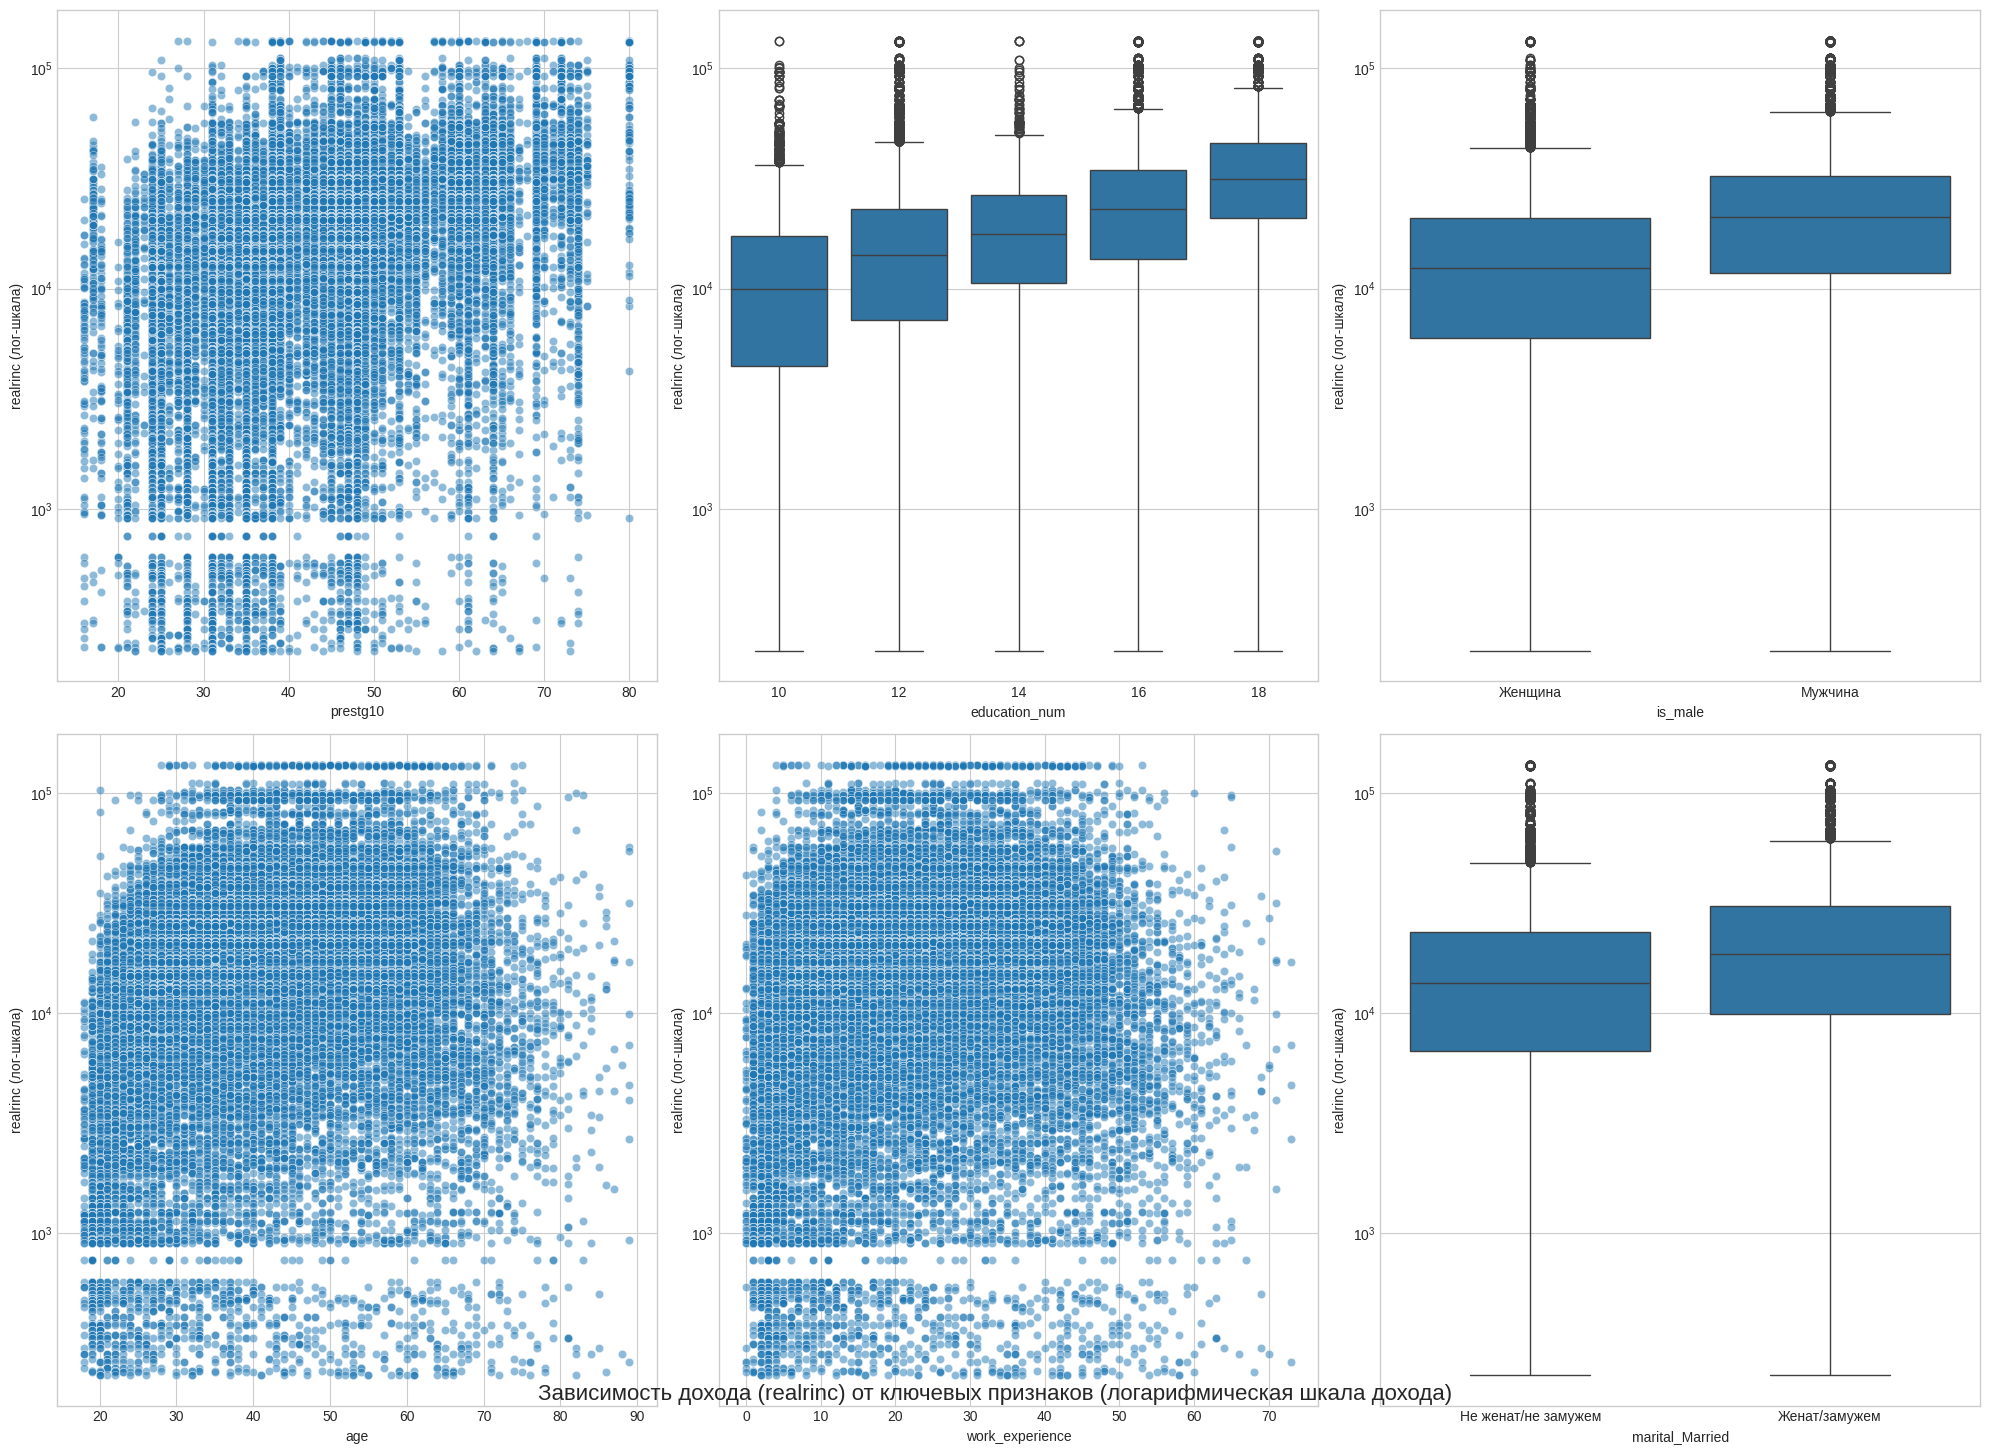

✅ График успешно сохранён в income_vs_features_logscale1.png


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ ===
df = pd.read_csv("gss_wages.csv", header=None)
df.columns = [
    "id", "year", "realrinc", "age", "occ10", "occupation", "prestg10",
    "childs", "wrkstat", "gender", "educcat", "maritalcat"
]

# Преобразуем realrinc в числовой
df["realrinc"] = pd.to_numeric(df["realrinc"], errors='coerce')
df = df.dropna(subset=["realrinc"])

# Обработка образования
edu_map = {
    "Less Than High School": 10,
    "High School": 12,
    "Junior College": 14,
    "Bachelor": 16,
    "Graduate": 18
}
df["education_num"] = df["educcat"].map(edu_map)
df = df.dropna(subset=["education_num"])
df["education_num"] = df["education_num"].astype(int)

# Пол
df["is_male"] = (df["gender"] == "Male").astype(int)

# Стаж
df["age"] = pd.to_numeric(df["age"], errors='coerce')
df["prestg10"] = pd.to_numeric(df["prestg10"], errors='coerce')
df = df.dropna(subset=["age", "prestg10"])
df["work_experience"] = (df["age"] - df["education_num"] - 6).clip(lower=0)

# Семейное положение
df["marital_Married"] = (df["maritalcat"] == "Married").astype(int)

# Удаляем экстремальные выбросы (опционально, но лог-шкала уже смягчает их влияние)
p99 = df["realrinc"].quantile(0.99)
df = df[df["realrinc"] <= p99]

# === 2. ВИЗУАЛИЗАЦИЯ С ЛОГ-ШКАЛОЙ ПО Y ===
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle("Зависимость дохода (realrinc) от ключевых признаков (логарифмическая шкала дохода)", fontsize=16, y=0.05)

# Общий список признаков и осей для удобства
plots = [
    ("prestg10", axes[0, 0], "scatter"),
    ("education_num", axes[0, 1], "box"),
    ("is_male", axes[0, 2], "box"),
    ("age", axes[1, 0], "scatter"),
    ("work_experience", axes[1, 1], "scatter"),
    ("marital_Married", axes[1, 2], "box")
]

for col, ax, plot_type in plots:
    if plot_type == "scatter":
        sns.scatterplot(data=df, x=col, y="realrinc", alpha=0.5, ax=ax)
    else:  # boxplot
        sns.boxplot(data=df, x=col, y="realrinc", ax=ax)

    # 🔑 Добавляем логарифмическую шкалу по Y
    ax.set_yscale('log')

    # Подписи
    ax.set_ylabel("realrinc (лог-шкала)")

# Настройка меток для категориальных переменных
axes[0, 2].set_xticklabels(["Женщина", "Мужчина"])
axes[1, 2].set_xticklabels(["Не женат/не замужем", "Женат/замужем"])

plt.tight_layout()

fig.savefig("income_vs_features_logscale1.png", dpi=150, bbox_inches='tight')

plt.show()

print("✅ График успешно сохранён в income_vs_features_logscale1.png")
